In [1]:
!pip3 install git+https://github.com/tyiannak/pyAudioAnalysis.git

  Cloning https://github.com/tyiannak/pyAudioAnalysis.git to /tmp/pip-req-build-ajtsbc10
  Running command git clone -q https://github.com/tyiannak/pyAudioAnalysis.git /tmp/pip-req-build-ajtsbc10
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.6-cp36-none-any.whl size=41158457 sha256=5e739a3621156b8b400a48face942043b5d7655226a4aba55ae4417dd4b6a0d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-73dm30_3/wheels/a5/f8/eb/c2cc1ce5c8873e2f9042015fea490db3909fa6ed77bbd842a6
Successfully built pyAudioAnalysis


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os, glob
import audio_recognize as ar
import audio_process as ap
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.cluster import KMeans

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# These values are selected based on the evaluation.py script and the results
# obtained from running these scripts on two long annotated recordings
ST_WIN = 0.002    # short-term window
ST_STEP = 0.002   # short-term step
MIN_VOC_DUR = 0.005

# The frequencies used for spectral energy calculation (Hz)
F1 = 30000
F2 = 110000

# Also, default thres value is set to 1.3 (this is the optimal based on
# the same evaluation that led to the parameter set of the
# short-term window and step
thres = 1.


There are three versions of the model in the next three cells. Choose one of them for a training task. Their only difference is the number of filters at the last layer of the encoder (4, 8, 16). I have chosen the middle one (8 filters) because the resulting feature dimension in the clustering task gave better results.

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 64), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 64, 3, padding =1)  
        # conv layer (depth from 64 --> 32), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        # conv layer (depth from 32 --> 4), 3x3 kernels
        self.conv3 = nn.Conv2d(32, 4, 3, padding=1)

        self.pool = nn.MaxPool2d((2,2), 2)

        ## decoder layers ##
        # a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 64, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(64, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x) # compressed representation

        if self.training:
            ## decode ##
            # add transpose conv layers, with relu activation function
            x = F.relu(self.t_conv1(x))        
            x = F.relu(self.t_conv2(x))
            # output layer (with sigmoid for scaling from 0 to 1)
            x = F.sigmoid(self.t_conv3(x))      
        return x

In [32]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 64), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 64, 3, padding =1)  
        # conv layer (depth from 64 --> 32), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        # conv layer (depth from 32 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(32, 8, 3, padding=1)

        self.pool = nn.MaxPool2d((2,2), 2)

        ## decoder layers ##
        # a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 64, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(64, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x) # compressed representation

        if self.training:
            ## decode ##
            # add transpose conv layers, with relu activation function
            x = F.relu(self.t_conv1(x))        
            x = F.relu(self.t_conv2(x))
            # output layer (with sigmoid for scaling from 0 to 1)
            x = F.sigmoid(self.t_conv3(x))      
        return x

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 64), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 64, 3, padding =1)  
        # conv layer (depth from 64 --> 32), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)

        self.pool = nn.MaxPool2d((2,2), 2)

        ## decoder layers ##
        # a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 64, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(64, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x) # compressed representation

        if self.training:
            ## decode ##
            # add transpose conv layers, with relu activation function
            x = F.relu(self.t_conv1(x))        
            x = F.relu(self.t_conv2(x))
            # output layer (with sigmoid for scaling from 0 to 1)
            x = F.sigmoid(self.t_conv3(x))      
        return x

In order to load the spectrograms from the shared folder in Google Drive, I created a shortlink of the folder in my drive.

In [6]:
def load_spectrograms (filename):
  train_data = []
  spectrogram, sp_time, sp_freq, fs = ap.get_spectrogram(filename,
                                                    ST_WIN, ST_STEP)
  # These should change depending on the signal's size
  spec_resize_ratio_freq = 4
  spec_resize_ratio_time = 4

  f_low = F1 if F1 < fs / 2.0 else fs / 2.0
  f_high = F2 if F2 < fs / 2.0 else fs / 2.0

  # define feature sequence for vocalization detection
  f1 = np.argmin(np.abs(sp_freq - f_low))
  f2 = np.argmin(np.abs(sp_freq - f_high))

  spectral_energy_1 = spectrogram.sum(axis=1)
  spectral_energy_2 = spectrogram[:, f1:f2].sum(axis=1)
  seg_limits, thres_sm, _ = ap.get_syllables(spectral_energy_2,
                                        spectral_energy_1,
                                        ST_STEP,
                                        threshold_per=thres * 100,
                                        min_duration=MIN_VOC_DUR)
  
  train_data += (ar.cluster_syllables(seg_limits, spectrogram,
                                          sp_freq, f_low, f_high,  ST_STEP, train = True))
  print(len(train_data))
  return train_data


In [7]:
train_data = []
# folder no1
path = "/content/drive/My Drive/amvoc/USV_MultiDaySetsByMouse/"
i=0
for folder in os.walk(path):
      dir = folder[0]
      for wavfile in folder[2]:
        if wavfile[-3:]=='WAV' or wavfile[-3:]=='wav':
          filename = dir+"/"+wavfile
          train_data += load_spectrograms(filename)

Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 38312.59it/s]


(150015, 250)
1347
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 39228.94it/s]


(150015, 250)
1278
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 41228.22it/s]


(150015, 250)
1332
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 40928.57it/s]


(150015, 250)
1112
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 39640.44it/s]


(150015, 250)
1221
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 39632.51it/s]


(150015, 250)
1242
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 40749.01it/s]


(150015, 250)
916
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 41467.61it/s]


(150015, 250)
1704
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 40049.54it/s]


(150015, 250)
1142
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 40735.87it/s]


(150015, 250)
1649
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 41200.14it/s]


(150015, 250)
1335
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 39623.28it/s]


(150015, 250)
1406
Computing spectrogram


100%|██████████| 150002/150002 [00:03<00:00, 41503.24it/s]


(150003, 250)
1037
Computing spectrogram


100%|██████████| 150002/150002 [00:03<00:00, 41551.44it/s]


(150003, 250)
1062
Computing spectrogram


100%|██████████| 150002/150002 [00:03<00:00, 40429.63it/s]


(150003, 250)
1348
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 41459.62it/s]


(150015, 250)
1411
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 41084.87it/s]


(150015, 250)
1036
Computing spectrogram


100%|██████████| 150015/150015 [00:03<00:00, 41869.50it/s]


(150015, 250)
850


In [8]:
# folder no2
path = "/content/drive/My Drive/amvoc/data/RecordingswithCageBedding/"
i=0
for folder in os.walk(path):
  for wavfile in folder[2]:
    if wavfile[-3:]=='WAV' or wavfile[-3:]=='wav':
      filename = folder[0]+"/"+wavfile
      train_data += load_spectrograms(filename)

Computing spectrogram


100%|██████████| 150010/150010 [00:03<00:00, 41299.11it/s]


(150010, 250)
903
Computing spectrogram


100%|██████████| 150010/150010 [00:03<00:00, 40859.90it/s]


(150010, 250)
895
Computing spectrogram


100%|██████████| 150010/150010 [00:03<00:00, 42970.92it/s]


(150010, 250)
1018
Computing spectrogram


100%|██████████| 150010/150010 [00:03<00:00, 42476.34it/s]


(150010, 250)
835


In [9]:
#folder no3
path = "/content/drive/My Drive/amvoc/data/"
for folder in os.walk(path):
  if folder[0]=='/content/drive/My Drive/amvoc/data/':
    for wavfile in folder[2]:
      if (wavfile[-3:]=='WAV' or wavfile[-3:]=='wav') and (wavfile[0]=='3'):
        filename = folder[0]+"/"+wavfile
        train_data += load_spectrograms(filename)

Computing spectrogram


100%|██████████| 150012/150012 [00:03<00:00, 42494.52it/s]


(150012, 250)
817
Computing spectrogram


100%|██████████| 150012/150012 [00:03<00:00, 40185.29it/s]


(150012, 250)
2567
Computing spectrogram


100%|██████████| 150012/150012 [00:03<00:00, 41929.40it/s]


(150012, 250)
112
Computing spectrogram


100%|██████████| 150012/150012 [00:03<00:00, 40659.22it/s]


(150012, 250)
412


Next part is for removing the false negatives from the dataset. 

In [10]:
for cur_image in train_data:
  if len(cur_image)==0:
    train_data.remove(cur_image)
test = []
# in order to classify the images, we use the following metrics
for cur_image in train_data:
      test.append([np.mean(cur_image/np.amax(cur_image)),np.var(cur_image), np.mean(cur_image-np.amax(cur_image))])

# clustering to split the two categories
clusterer = KMeans(n_clusters=2)
y = clusterer.fit_predict(test)
train_data = np.array(train_data)
# we compare the mean of variances of the images in the two categories
var_0, var_1 = [], []
for element in train_data[y==1]:
  var_1.append(np.var(element))
for element in train_data[y==0]:
  var_0.append(np.var(element))
var_1 = np.mean(var_1)
var_0 = np.mean(var_0)
# we choose the images with the highest variance (true positives)
if var_1 > var_0:
    train_data = list(train_data[y==1])
else:
    train_data= list(train_data[y==0])
print(len(train_data))

22409


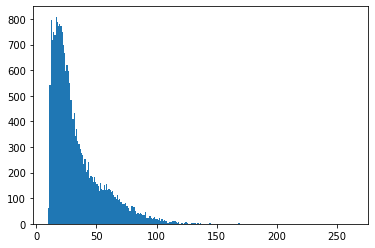

In [11]:
# histogram of durations (in samples) of all the spectrograms
# based on that, we choose the width of the spectrograms to be 64 samples (it has to be multiple of 4 because of the 3 max pooling layers)
duration = []
for image in train_data:
    duration.append(image.shape[0])
plt.hist(duration, bins = range(min(duration), max(duration)))
plt.show()

In [12]:
time_limit = 64
# cropping/padding the images and normalizing between (0,1)
for i in range(len(train_data)):
    if len(train_data[i])>time_limit:
        train_data[i] = train_data[i][int((len(train_data[i])-time_limit)/2):int((len(train_data[i])-time_limit)/2)+time_limit,:]/np.amax(train_data[i])
    elif len(train_data[i])<time_limit:
        train_data[i] = np.pad(train_data[i]/np.amax(train_data[i]), ((int((time_limit-train_data[i].shape[0])/2), (time_limit-train_data[i].shape[0]) - int((time_limit-train_data[i].shape[0])/2)),(0,0)))
    else:
        train_data[i] = train_data[i]/np.amax(train_data[i])


In [34]:
train_data=np.array(train_data)

train_data = train_data.reshape(train_data.shape[0], 1, train_data.shape[1], train_data.shape[2])
dataset = TensorDataset(torch.tensor(train_data, dtype = torch.float))

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = True)
model = ConvAutoencoder()

# specify loss function
criterion = nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 8

In [35]:
from torchsummary import summary
if torch.cuda.is_available():
    model.cuda()
summary(model, (1, 64, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 160]             640
         MaxPool2d-2           [-1, 64, 32, 80]               0
            Conv2d-3           [-1, 32, 32, 80]          18,464
         MaxPool2d-4           [-1, 32, 16, 40]               0
            Conv2d-5            [-1, 8, 16, 40]           2,312
         MaxPool2d-6             [-1, 8, 8, 20]               0
   ConvTranspose2d-7           [-1, 32, 16, 40]           1,056
   ConvTranspose2d-8           [-1, 64, 32, 80]           8,256
   ConvTranspose2d-9           [-1, 1, 64, 160]             257
Total params: 30,985
Trainable params: 30,985
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 8.56
Params size (MB): 0.12
Estimated Total Size (MB): 8.72
---------------------------------------------

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of epochs is chosen after trials. The loss isn't really improving, but we noticed that reconstruction of images was better if the model was trained for e.g. 8 epochs.

In [37]:
model = model.float()

for epoch in range(n_epochs):

    for feats in train_loader:
    # monitor training loss
        train_loss = 0.0

        feats[0] = feats[0].to(device)
        ###################
        # train the model #
        ###################
        
        # _ stands in for labels, here
        model.train()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(feats[0].float())

        loss = criterion(outputs, feats[0].float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

        train_loss += loss.item()
        
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))
print(outputs.shape)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



Epoch: 0 	Training Loss: 0.000122
Epoch: 1 	Training Loss: 0.000102
Epoch: 2 	Training Loss: 0.000154
Epoch: 3 	Training Loss: 0.000115
Epoch: 4 	Training Loss: 0.000107
Epoch: 5 	Training Loss: 0.000144
Epoch: 6 	Training Loss: 0.000095
Epoch: 7 	Training Loss: 0.000141
torch.Size([9, 1, 64, 160])


In [38]:
# we test the autoencoder on data we didn't use for training
test_data = load_spectrograms( "/content/drive/My Drive/B148_test_small.wav")

  0%|          | 0/29998 [00:00<?, ?it/s]

Computing spectrogram


100%|██████████| 29998/29998 [00:00<00:00, 42417.11it/s]


(29999, 250)
223


In [39]:
time_limit = 64
for i in range(len(test_data)):
    
    if len(test_data[i])>time_limit:
        test_data[i] = test_data[i][int((len(test_data[i])-time_limit)/2):int((len(test_data[i])-time_limit)/2)+time_limit,:]/np.amax(test_data[i])
    elif len(test_data[i])<time_limit:
        test_data[i] = np.pad(test_data[i]/np.amax(test_data[i]), ((int((time_limit-test_data[i].shape[0])/2), (time_limit-test_data[i].shape[0]) - int((time_limit-test_data[i].shape[0])/2)),(0,0)))
    else:
        test_data[i] = test_data[i]/np.amax(test_data[i])

In [40]:
test_data=np.array(test_data)
test_data = test_data.reshape(test_data.shape[0], 1, test_data.shape[1], test_data.shape[2])
test_dataset = TensorDataset(torch.tensor(test_data, dtype = torch.float))

batch_size = 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
outputs = []
model.train()
with torch.no_grad():
    for data in test_loader:
        outputs += model(data[0].to(device))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



In [41]:
for i in range(len(outputs)):
    outputs[i] = outputs[i].cpu().detach().numpy()

Reconstruction example

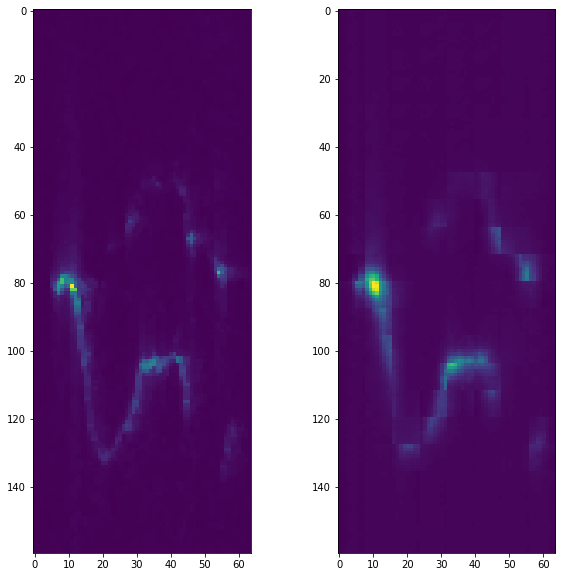

In [42]:
fig = plt.figure(figsize = (10,10))
fig.add_subplot(1,2,1)
plt.imshow(test_data[156][0].T)
fig.add_subplot(1,2,2)
plt.imshow(outputs[156].reshape(outputs[0].shape[1], outputs[0].shape[2]).T)
plt.show()

Reconstruction example

In [ ]:
model = model.to("cpu")

In [ ]:
path = "/content/drive/My Drive/model_2"
torch.save(model, path)

In [ ]:
check = torch.load("/content/drive/My Drive/model_2")